# Statistical and Clinical Validation of Phenotypes

This notebook evaluates the three data-driven phenotypes by linking them to both laboratory profiles and clinical outcomes, with a particular focus on intensive care unit (ICU) admission.

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, kruskal

df = pd.read_csv("../data/processed/02_clustered_data.csv")
sns.set_style("whitegrid")
plt.rcParams["figure.dpi"] = 100
print(f"Loaded: {len(df)} patients, {len(df.columns)} columns")

Loaded: 603 patients, 52 columns


## 1. Clinical Outcome: ICU Admission (Gold Standard)

Chi-Square Test: chi2=12.61, p-value=0.0018

ICU Admission Rates:
  Cluster 0: 2.5%
  Cluster 1: 5.8%
  Cluster 2: 10.0%


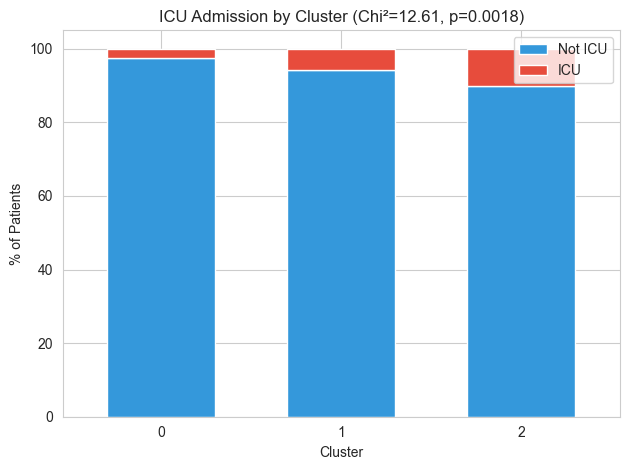

In [8]:
icu_col = "Patient addmited to intensive care unit (1=yes, 0=no)"

# Chi-Square test and ICU rates
table = pd.crosstab(df[icu_col], df["Cluster"])
chi2, p_value, dof, expected = chi2_contingency(table)
print(f"Chi-Square Test: chi2={chi2:.2f}, p-value={p_value:.4f}")

rates = df.groupby("Cluster")[icu_col].mean() * 100
print("\nICU Admission Rates:")
for c in sorted(rates.index):
    print(f"  Cluster {c}: {rates[c]:.1f}%")

# Stacked bar chart (normalized to 100%)
cross = pd.crosstab(df["Cluster"], df[icu_col], normalize="index") * 100
cross.columns = ["Not ICU", "ICU"]
cross.plot(kind="bar", stacked=True, color=["#3498db", "#e74c3c"], width=0.6)
plt.xlabel("Cluster")
plt.ylabel("% of Patients")
plt.title(f"ICU Admission by Cluster (Chi²={chi2:.2f}, p={p_value:.4f})")
plt.legend(title="")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("../figures/icu_admission_by_cluster.png", dpi=150, bbox_inches="tight")
plt.show()

## 2. Biomarker Analysis (Biological Profile)

In [10]:
selected_features = ["Rods #", "Hemoglobin", "Hematocrit", "Basophils", "Urea", "Creatinine"]
available = [f for f in selected_features if f in df.columns]
if len(available) < len(selected_features):
    missing = set(selected_features) - set(available)
    if "Lactic Dehydrogenase" in df.columns:
        available.append("Lactic Dehydrogenase")
    print(f"Using features: {available}")

print("Kruskal-Wallis p-values:")
for feat in available:
    g0 = df.loc[df["Cluster"] == 0, feat].dropna()
    g1 = df.loc[df["Cluster"] == 1, feat].dropna()
    g2 = df.loc[df["Cluster"] == 2, feat].dropna()
    if len(g0) < 2 or len(g1) < 2 or len(g2) < 2:
        continue
    stat, p = kruskal(g0, g1, g2)
    print(f"  {feat}: p = {p:.2e}")

Kruskal-Wallis p-values:
  Rods #: p = 4.92e-45
  Hemoglobin: p = 6.46e-21
  Hematocrit: p = 5.72e-21
  Basophils: p = 1.07e-38
  Urea: p = 4.18e-08
  Creatinine: p = 7.21e-11


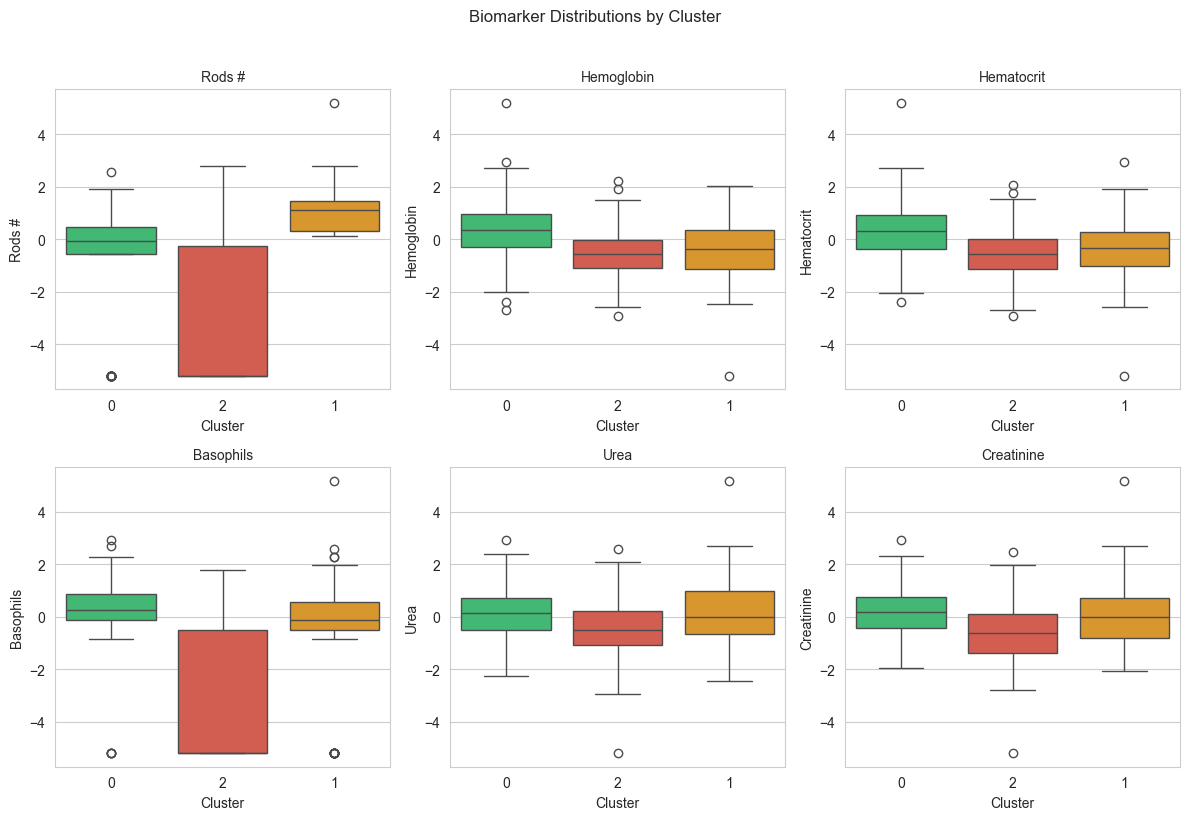

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()
palette = {"0": "#2ecc71", "1": "#f39c12", "2": "#e74c3c"}

for i, feat in enumerate(available):
    ax = axes[i]
    df_plot = df[[feat, "Cluster"]].dropna()
    df_plot["Cluster"] = df_plot["Cluster"].astype(str)
    sns.boxplot(data=df_plot, x="Cluster", y=feat, hue="Cluster", palette=palette, legend=False, ax=ax)
    ax.set_title(feat, fontsize=10)

plt.suptitle("Biomarker Distributions by Cluster", fontsize=12, y=1.02)
plt.tight_layout()
plt.savefig("../figures/biomarker_boxplots_by_cluster.png", dpi=150, bbox_inches="tight")
plt.show()

## 3. Clinical Interpretation

The three clusters can be interpreted as clinically meaningful phenotypes. Cluster 0 represents a Mild group with a low ICU admission rate and largely unremarkable blood counts. Cluster 1 corresponds to a Moderate phenotype with intermediate ICU risk and a mixed biomarker profile that suggests partial physiological stress. Cluster 2 reflects a Severe phenotype with the highest ICU risk, markedly elevated counts of Rods # and related immature white cells indicating a Left Shift in the myeloid lineage, and lower haemoglobin levels consistent with impaired oxygen-carrying capacity.

In [12]:
summary = pd.DataFrame([
    {"Cluster": 0, "Phenotype": "Mild", "Description": "Low ICU rate, normal blood counts."},
    {"Cluster": 1, "Phenotype": "Moderate", "Description": "Intermediate ICU risk, mixed biomarker profile."},
    {"Cluster": 2, "Phenotype": "Severe/Critical", "Description": "Highest ICU risk, elevated Rods # (Left Shift), low Hemoglobin."},
])
summary.to_csv("../data/processed/cluster_descriptions.csv", index=False)
print("Saved: data/processed/cluster_descriptions.csv")
summary

Saved: data/processed/cluster_descriptions.csv


,Cluster,Phenotype,Description
0,0,Mild,"Low ICU rate, normal blood counts."
1,1,Moderate,"Intermediate ICU risk, mixed biomarker profile."
2,2,Severe/Critical,"Highest ICU risk, elevated Rods # (Left Shift)..."


## 4. Summary

This validation notebook demonstrates that the three unsupervised phenotypes correspond to clinically meaningful groups. ICU admission rates increase monotonically from the Mild cluster, through the Moderate group, to the Severe phenotype, providing a clear outcome gradient. The biomarker analysis shows that the Severe cluster is characterized by markedly elevated Rods # and related immature myeloid cells, together with lower haemoglobin, consistent with a Left Shift and impaired oxygen-carrying capacity. Taken together, these results suggest that the clusters capture a coherent spectrum of disease severity rather than arbitrary partitions of the data, and they motivate the supervised modelling in Notebook 04, where we test how well these phenotypes can be predicted from laboratory measurements alone.